In [2]:
import warnings
import os

import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import alphashape
from geonetworkx.tools import get_alpha_shape_polygon
from shapely.geometry import Point, Polygon, MultiPolygon, shape, MultiLineString, LineString
from shapely.ops import unary_union

from matplotlib import pyplot as plt

from osgeo import gdal

from shapely.errors import ShapelyDeprecationWarning

import pydeck as pdk


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


from scipy.spatial.distance import cdist
import rasterio
from rasterio.transform import from_origin
from rasterio.io import MemoryFile

from rasterio.mask import mask
from rasterio.plot import show

from rasterio.transform import Affine
from rasterio import features

from collections import defaultdict

from PIL import Image

from shapelysmooth import taubin_smooth

import base64
from io import StringIO


In [3]:
# App structure
# https://levelup.gitconnected.com/8-simple-steps-to-build-your-first-streamlit-app-91fe7b3bef9e

In [4]:
def plug_shape_holes(geom):
    if geom.geom_type.lower() == 'multipolygon':
        return MultiPolygon([Polygon(p.exterior) for p in shape_concave.geoms]).buffer(0)
    if geom.geom_type.lower() == 'polygon':
        return Polygon(geom.exterior)
    
def polygon_to_line(poly):
    lines = []
    boundary = poly.boundary
    if boundary.type.lower() == 'multilinestring':
        for line in boundary.geoms:
            lines.append(line)
    else:
        lines.append(boundary)
    
    print(lines)
    return MultiLineString(lines).buffer(0)

In [5]:
source_ = [45.503032, -73.566424]
distance = 1000
interval = 150
alpha = 85
offset = 50
plug_holes = True
force_single = False

In [6]:
# Build the graph
graph = ox.graph_from_point(source_, network_type='walk', dist=distance + 250)
nodes, edges = ox.utils_graph.graph_to_gdfs(graph)

# Get UTM crs for distance based geoprocessing
utm_crs = nodes.estimate_utm_crs()

# Construct GeoDataFrames
source = gpd.GeoDataFrame(geometry=[Point(source_[::-1])], crs='epsg:4326')
buffer = source.to_crs(utm_crs).buffer(distance).to_crs('epsg:4326')

# Clip
nodes = nodes.clip(buffer)
edges = edges.clip(buffer)

In [7]:
# Find the closest node to source_
start_node = ox.nearest_nodes(graph, source_[1], source_[0])

# Get start node as gdf for plotting
start_point = nodes[nodes.index == start_node].copy()

In [8]:
# Calculate isochrone
subgraph = nx.ego_graph(graph, start_node, radius=distance, distance='length')
acc_nodes, acc_edges = ox.utils_graph.graph_to_gdfs(subgraph)

# Convex shape
shape_convex = acc_nodes.unary_union.convex_hull
shape_convex_df = gpd.GeoDataFrame(geometry=[shape_convex], crs='epsg:4326')

# Concave shape
pts = list(acc_nodes.to_crs(utm_crs).geometry.apply(lambda p: (p.x, p.y)))
shape_concave = get_alpha_shape_polygon(pts, alpha)

# Concave shape - CONDITION - no holes
if plug_holes:
    shape_concave = plug_shape_holes(shape_concave)

# Concave shape - CONDITION - single part geometry
if force_single:
    while shape_concave.geom_type.lower() == 'multipolygon':
        if new_alpha == 100:
            break
        new_alpha += 1
        shape_concave = get_alpha_shape_polygon(pts, new_alpha)
        if plug_holes:
            shape_concave = plug_shape_holes(shape_concave)
        st.write('Overwritten alpha percentile:', new_alpha)

shape_concave_df = gpd.GeoDataFrame(geometry=[shape_concave], crs=utm_crs).to_crs(
    'epsg:4326')

# Offset shape
shape_offset = acc_edges.to_crs(utm_crs).buffer(offset, cap_style='round').unary_union
shape_offset_df = gpd.GeoDataFrame(geometry=[shape_offset], crs=utm_crs).to_crs('epsg:4326')

In [110]:
# Interpolation

# Prepare points layer with column with values to interpolate
node_dists = nx.single_source_dijkstra_path_length(subgraph, start_node, weight='length')
node_dists = pd.DataFrame(data=[(k, v) for k, v in node_dists.items()], columns=['osmid', 'dist']).set_index('osmid')
node_dists = gpd.GeoDataFrame(node_dists.merge(acc_nodes, left_index=True, right_index=True), geometry='geometry', crs=acc_nodes.crs)

# Add color columns
colormap = plt.cm.RdYlGn
normalized_values = (node_dists['dist'] - node_dists['dist'].min()) / (node_dists['dist'].max() - node_dists['dist'].min())
node_dists['color_hex'] = normalized_values.apply(lambda x: mcolors.to_hex(colormap(x)))
node_dists['color_rgb'] = normalized_values.apply(lambda x: list((np.array(mcolors.to_rgb(colormap(x))) * 255).astype(np.uint8)))

In [111]:
acc_nodes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
8190992384,45.504948,-73.571876,4,NaN,NaN,POINT (-73.57188 45.50495)
8190992385,45.504458,-73.572579,4,NaN,NaN,POINT (-73.57258 45.50446)
8190992386,45.503972,-73.573094,3,NaN,NaN,POINT (-73.57309 45.50397)
9041797124,45.502946,-73.560729,3,NaN,NaN,POINT (-73.56073 45.50295)
8190992389,45.504552,-73.572492,4,NaN,NaN,POINT (-73.57249 45.50455)
...,...,...,...,...,...,...
29794288,45.510681,-73.559931,4,NaN,NaN,POINT (-73.55993 45.51068)
8190992379,45.504382,-73.572430,4,NaN,NaN,POINT (-73.57243 45.50438)
8190992380,45.503248,-73.573535,3,NaN,NaN,POINT (-73.57354 45.50325)


In [115]:
eval(str(node_dists.color_rgb.iloc[0]))

[165, 0, 38]

In [10]:
# https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array

# IDW
target_resolution = 10  # m

# Get reference to coordinates and distance values from nodes
points = node_dists.to_crs(utm_crs).geometry.values
points = [(p.x, p.y) for p in points]
vals = node_dists['dist'].values

# Calculate the minimum and maximum bounds of the GeoDataFrame
xmin, ymin, xmax, ymax = buffer.to_crs(utm_crs).total_bounds

# Calculate the number of pixels in the x and y directions based on the target resolution
num_pixels_x = int((xmax - xmin) / target_resolution)
num_pixels_y = int((ymax - ymin) / target_resolution)

# Create a regular grid of points for interpolation based on the target resolution
grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, num_pixels_x), np.linspace(ymin, ymax, num_pixels_y))

# Calculate the distance matrix between the points and grid points
distances = cdist(points, np.c_[grid_x.ravel(), grid_y.ravel()])

# Set the power parameter (p value) for IDW
p = 3  # Adjust the value as needed

# Perform IDW interpolation
weights = 1 / np.power(distances, p)
# weights = 1 / distances
interpolated_elevation = np.sum(weights * vals[:, np.newaxis], axis=0) / np.sum(weights, axis=0)

# Reshape the interpolated elevation values to match the grid shape
interpolated_elevation = interpolated_elevation.reshape(grid_x.shape)

# Create an in-memory raster using rasterio
height, width = interpolated_elevation.shape
# transform = from_origin(xmin, ymax, (xmax - xmin) / width, (ymax - ymin) / height)
transform = Affine.translation(xmin - target_resolution / 2, ymin - target_resolution / 2) * Affine.scale(target_resolution, target_resolution)

# Prepare mask geometry (will need to be inverted)
shapes = [buffer.to_crs(utm_crs).values[0]]

# Profile
profile = {
    # 'driver': 'MEM',
    'driver': 'GTiff',
    'dtype': rasterio.float32,
    'count': 1,
    'width': width,
    'height': height,
    'transform': transform,
    'crs': utm_crs
}

# Write the interpolated elevation values to the in-memory raster
with MemoryFile() as memfile:
    with memfile.open(**profile) as dataset:
        dataset.write(interpolated_elevation[::-1], 1)
        # dataset.write(interpolated_elevation, 1)

    
    # Read the dataset right away
    src = memfile.open(**profile)
    
    # Unmaksed image
    img = src.read(1)
    
    # Masked inmage
    img_masked, transform = mask(src, shapes, crop=True, filled=False)

In [11]:
display(img_masked.min())
img_masked.max()

7.7818685

999.1764

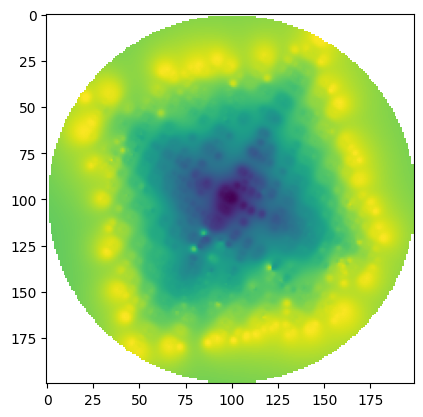

<Axes: >

In [12]:
show(img_masked)
# plt.imshow(out_img.squeeze())

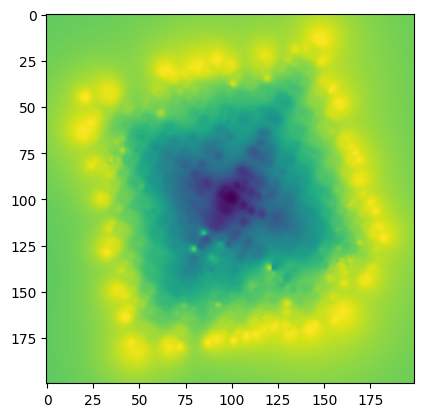

<Axes: >

In [13]:
show(img)

In [17]:
type(img_masked)

numpy.ma.core.MaskedArray

In [53]:
# Convert to RGB image

colormap = plt.cm.RdYlGn_r

# Convert the masked array to a regular array by filling the mask with 0s
img_arr = np.ma.filled(img_masked, fill_value=0).squeeze()

# Normalize the data to the range [0, 1]
arr_norm = (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min())

# Apply the colormap to the normalized data
arr_rgba = colormap(arr_norm)

# Convert to byte
arr_rgba = (arr_rgba[:, :, :4] * 255).astype(np.uint8)

# Correct the alpha band values
arr_rgba[:, :, 3:][img_masked.mask.squeeze()] = 0

# Build PIL image
# arr_rgba = arr_rgba[:, :, :-1]
img_rgba = Image.fromarray(arr_rgba)


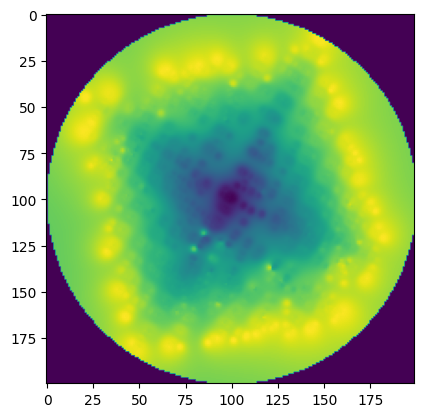

In [54]:
plt.imshow(img_arr)

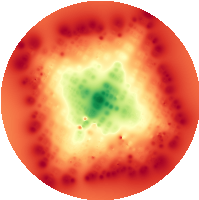

In [55]:
img_rgba

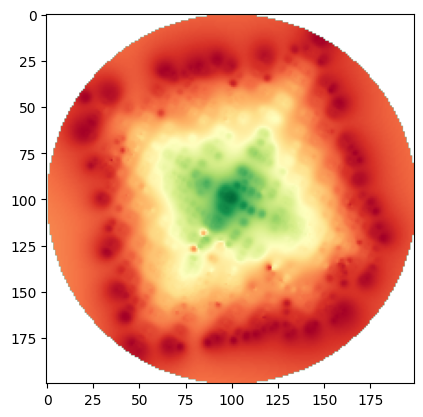

In [56]:
plt.imshow(img_rgba)

In [97]:
img_rgba.getbands()

('R', 'G', 'B', 'A')

In [61]:
img_rgba.save('pil_idw.png')

In [58]:
# img_rgba_encoded = base64.b64encode(img_rgba.tobytes()).decode('utf-8')[:-1]
img_rgba_encoded = str(base64.b64encode(img_rgba.tobytes()))[2:-1]

type(img_rgba_encoded)
# img_rgba_encoded

str

In [59]:
buffer.envelope.total_bounds

array([-73.57922043,  45.49403368, -73.55362768,  45.5120303 ])

In [85]:
from io import BytesIO

In [98]:
img_ = Image.open(r"./pil_idw.png")
im_file = BytesIO()
# img_.save(im_file, format="png")
img_rgba.save(im_file, format="png")
im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
im_b64 = str(base64.b64encode(im_bytes))[2:-1]
# im_b64

{
  "initialViewState": {
    "latitude": 45.494033683479515,
    "longitude": -73.57922043288622,
    "zoom": 10
  },
  "layers": [
    {
      "@@type": "BitmapLayer",
      "bounds": [
        [
          -73.57922043288622,
          45.494033683479515
        ],
        [
          -73.57922043288622,
          45.512030301387256
        ],
        [
          -73.55362767514126,
          45.512030301387256
        ],
        [
          -73.55362767514126,
          45.494033683479515
        ]
      ],
      "id": "95a179d9-0500-405c-96a9-516c4da03250",
      "image": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMcAAADICAYAAABcU/UTAACFSUlEQVR4nO393a9sSZYnCP1sme3tfvyee29EZFZkVmX1V01pqruB1ojR0DQgwYwEjBAajdBoBOKBJ6R55r9BPPAEQqiFUGuERg0DrQHRGroblRpR1dnUVHZld1ZmRWbEjXvjXD/ue5st42HZMltmvv3ccyPixkdmWOiG+3Hfvj/tZ+vrt9Zy+I/+Nr4b343vxuUIX/cJ/DqPT85zfhf7zelyt987rO5dHOs3eXwHji9hfHycNkGQ8XbYcL6f31sg6L7n9v2v7kIGAB5+8+Hz9B1oPuf4DhyfY2yBwU7UxwxHl3P2bcCgYwTDuN1fvKBugx+8z9+B5ZHjO3A8YlgwZM5XJcLWRB0HFenwtmB66DjX9rX1+S8+djknrn//9ofuO7BcGd+B48pQQGyB4SEQPDTpHblHAegxYzzOVYAYIGxt/+e/yFkl1o9+5L8DihnfgcOMa4B47Er9pu/eNLZUrWv7vfj7CgjedE4KjMwZP/2zNeeUkTnjr/7+7jceKL/x4BhVJh0WEF90lW7fA87T5neO3BuB9RAgHgvKLbsmcwYPv//Jj0+ZIyMnxu//rdvfSKD8RoLjk/Oc88bkfywgtkDw6MnJ6YqE2AbNxe+vAGKc9Pa7TePfLgTlvUoNfdXv/tk/epkzZ6SY8V/+b77/GwOU3yhwKCgy8qOkxDVAXK7gb6dK5ZQv3LbAw1Jn+5zyxWejBJAPM+iKynYNGPKeu7+ZgX/8n77IMQL/9f/+rz9IfiPAYUEBXEqKNwHiITB8Xhsjc37QxrDfXTu+Xd3H8xpH2gRkv7/+MwazlSDmXwb+wd97kZcF+O/9B7++IPm1BodGqC8m0/D3myTENTBsrdJvkiLdBH1gRX9ovxYU47WNx78GiIv9D1KDL/7G5r+/978RSfI/+p/9+oHk1xIcL9ZdtpPlTaB4LCC4A9HjPVhb26lkqCv6I4ByDRRb6tXW8aw6p8cf75OqU/3x2r/x7xjl3//uf/UiA8D/+H/+6wOSXytwvFh3zRW7IS2ugeIhPX4LEI81hB8aOjmdd1XFslbHlnn+kOFsJ/XFsTw9qMaNwLgmNa4NZiAlef+//V++yES/HiD5tQHHNWBYaXENFA8Ztg+pLddsFXuMrWEnq5209v3Wr0dpsTWh7blUAFapRPXzB+2MlMGRt9Wp8jMa0Otc+4xZJMm3HSDfenB8mva5Xz2vA2MLFI8BxNZnWyrZaINctT9WhvOuqlHOExy7C9VnHFsqUFpTD5ThHBw5OHbI5OA4w0+++87eH+YMXgUUKV63MwABQghASJcql46/+79+kecZ+Pf+p99OkHxrwfFp2ldJoa8jMEaVY9MO+QKA2PISPTZg6FjUKFcmLZETkLzJ7tgAxrjK20GUQSQSiUBISPCT74KO1m3LkasdoaPaF6kHxzy398vSfkPU//v7f/dFDgH4d/79bxdIvpXg2AKGjoeAMYLiMSrTFiCugWb8rWzfvwKqfmQQ9Su7rOlU99HZJYMUtMDYWuXtsUIQkAAMAiETA+iByCz7WhbgdBIgEAGhCBrOzQAHitQIBgQOiKEHSAjye33///xPXuT/xr/77QHItwocL3GTr6/m+VHA4AEkmxLjAQnR7XsDBPb9tVfVzWXStJUdQCdFgN4+sOrhaDDrat/ZBcUOYG4A0XvgfQ9A3d+yAKez7EulQ/ANGCPwdOLPc5MezL3kqCByEkQMAfg3/tvffJB8a8DxadrnMYh3zXbQ7xQYvA4emA0jXfazbT/Yiai/u6Zn278v3J/mFMnJpLETF2A4dsBEIMjqPl6TnlvmXgWKsak99nxCAKhM1hiBicp9IK6OAUCk0+ie1d/Dt4muoAmhgc9ez6iSdeAw//7oH77If/PvfLMB8q0Ah6pRwJZXyKzeI/XhCjBGA/0hQ/oaKB4NjkEdsasq57YqhwCIqlWONahZ7dz6g1l7wEoPYJAaZVI/5Gr2wRVJ1n6vk5sZwFykxNRfh45r7DCVGuP2/+wfvcx//d96/o0FyDcaHA+C4oqdMapS1TVZvDBbvvytcbH/Bzw3F+DI7fMLlcdMqnkGODS9HiiTEVzVHf3Ksnmbitgfxx6v7itcfm8O1w0KhP0+gRlYZvn9ftf2QUZlslLPSop6DzZUSHuNen3//A8/y0TuG8n8/caC48W6q2rUOLYM6PH7nDJS5A4YvKbOXfnQKqrjGiisVNDtdOiKDTRgLGs/icLGndfJJq8ZjjLSyvATXZVyW5HrWAJyM22f6zjUuAeAae/xbBaVzZFrcZfIVa0ar9PGN2IU22MEkVXNdFiHwJ/+8X3+vb9x840CyDcSHJ+c55yRH02+G6WGft4ZrWtCWnkzuGXHGNwCLldlnWhv2oeVGlZ6WD29W1GzVbEAIgYFAnOjlhA5JLMo1AmXzH7c9nXots43tzEbr5eCIew83GHq4iBpTaCVQQtflZzLWjxdg0t36zzss1Wp+JMfn/Jf+4P9NwYg3zhwfHycBBj+evLPm7hEVZ1Sm8MAI8XcqThb3hd9D2yoLKn33Dy0D/39aA903qoNVah6m6gZ0BjiH45ctU+soQs0N+vWkN+53o1b7osvv3Ge4HceNLUL8asHrww6R7mnkbvzXhbjrdLH8ojFZ+ST/Ys/OedvShbiNwocv7oLVWI8Nkeiy8UYpYZx33JkrEve9Ox0BuiG4TgavRfgMCpL8JeTVcfWKmr3r+di9fUQ2vU5L+qVXTiuqWf2mBpvCEHsCpraxFd3LpkiJbINwQcSKUMOeScLjd95pHMCrwnxnEDENS5yOokbePROjddv4zdb48/+dMl/5ffmrx0g3whwfPTSZwDgYmPYOXSVLDcYzNelDIPXJjGWpV/JdXQ++dzcn8C2xLDqlZUIqhaFYb/2O/u57n8LqNFfGtDOi5s36+rPucUjiifJ2jcayAsBmGYHP8nEV3Do/Y0n+UHYB/i9ryu6IwfSiPouw68JvPMCjClhPa4IMVWJp/djns099T1gHnquOn76Z2sGgL/8V6avDSRfOzh+8bHLXGh2lcZtglPjYvumXGurUtWgH+cLw1iNRhswsx6YEAA2erwFwbJe2iE2aKYGKFA+m9r7KmEGL1WVQKlti5257o5aQnCc4bhf8YEGkmVpn4UA7PeA33n4XahSQb4E/EQINzIV/CTHSZFBAGjy9TMAyBMhrQyaCMlIn3lh7M35zpOci57P2wBDn6PzDv/qX8b8u38pfC0A+VrB8ee/4MwwBLiNAgSqIWzVe3pTmZs+Mt4kxrL0ExzodX0dWyu7Na51so9xhVGVULCNwTW7nX6/rPL3bH6vqo2dVESuSg9CvlQPzbmEAPjZI+xEKqi6pKorTYRQDH
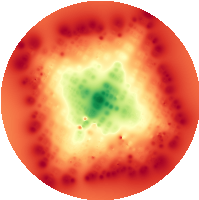

In [99]:
# https://github.com/visgl/deck.gl/issues/4977#issuecomment-700155508
import pydeck as pdk

xmin, ymin, xmax, ymax = buffer.envelope.total_bounds


# base64-encoded image string of a red dot
# IMG_URL = '"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAUAAAAFCAYAAACNbyblAAAAHElEQVQI12P4//8/w38GIAXDIBKE0DHxgljNBAAO9TXL0Y4OHwAAAABJRU5ErkJggg=="'
# IMG_URL = fr'"data:image/png;base64,{img_rgba_encoded}"'
# IMG_URL = '"data:image/png;base64,'+ str(img_rgba_encoded.decode('utf-8')) + '"'
# IMG_URL = f'"img_rgba_encoded"'

# IMG_URL = r"./pil_idw.png"
IMG_URL = fr'"data:image/png;base64,{im_b64}"'

# Specifies the corners of the image bounding box
# BOUNDS = [
#     [-122.52690000000051, 37.70313158980733],
#     [-122.52690000000051, 37.816395657523195],
#     [-122.34604834372873, 37.816134829424335],
#     [-122.34656848822227, 37.70339041384273],
# ]
BOUNDS = [
    [xmin, ymin],
    [xmin, ymax],
    [xmax, ymax],
    [xmax, ymin]
]

bitmap_layer = pdk.Layer("BitmapLayer", data=None, image=IMG_URL, bounds=BOUNDS, opacity=0.7)

view_state = pdk.ViewState(latitude=ymin, longitude=xmin, zoom=10)

# r = pdk.Deck(bitmap_layer, initial_view_state=view_state, map_style=pdk.map_styles.SATELLITE)
r = pdk.Deck(bitmap_layer, initial_view_state=view_state)


# r.to_html()
r

In [116]:
# IMG_URL

In [126]:
type(img_rgba)

PIL.Image.Image

In [144]:
# Create contours

# Create the levels list
# levels = list(range(0, distance, interval)) + [distance]
levels = list(range(0, distance, interval))
levels_ =[(levels[i],  levels[i + 1]) for i in range(len(levels) - 1)]

# Discreetize the raster
img_ = img_masked
for (low, high) in levels_:
    img_[(img_ > low ) & (img_ <= high)] = high

# Extract features (connected component geometries) for every pixel value
geoms = []
contour_vals = []

for contour in features.shapes(img[::-1], transform=transform):
    contour_geom, contour_val = contour
    # geoms.append(shape(contour_geom).boundary.simplify(target_resolution, preserve_topology=True))
    geoms.append(shape(contour_geom))
    contour_vals.append(contour_val)
    
# Create GeoDataFrame
geoms = gpd.GeoSeries(geoms, crs=utm_crs)
contour_vals = pd.Series(contour_vals, name='contour')
contours = gpd.GeoDataFrame({'contour': contour_vals, 'geometry': geoms}, geometry='geometry')

# Filter
contours = contours[contours.contour.isin(levels)].sort_values('contour').reset_index(drop=True)
contours = contours.dissolve('contour')

# Get correct ring
def get_correct_ring(g):
    # print(g)
    idx_max = np.array([x.area for x in g.geoms]).argmax()
    interiors = g.geoms[idx_max].interiors
    
    if len(interiors) > 1:

        idx_max = np.array([x.length for x in interiors]).argmax()
        ring = interiors[int(idx_max)]

        return LineString(ring)
    else:
        return g.geoms[idx_max].boundary

contours.geometry = contours.geometry.apply(get_correct_ring)

# Smooth the contours
contours.geometry = contours.geometry.apply(lambda x: taubin_smooth(x))

In [142]:
contours.explore()

In [149]:
contours.reset_index()

,contour,geometry
0,150.0,"LINESTRING (612037.713 5039765.746, 612017.892..."
1,300.0,"LINESTRING (612063.719 5039817.257, 612054.758..."
2,450.0,"LINESTRING (611812.587 5039740.834, 611821.449..."
3,600.0,"LINESTRING (612057.026 5039500.033, 612062.040..."
4,750.0,"LINESTRING (611770.390 5039320.029, 611781.464..."
5,900.0,"LINESTRING (611626.838 5039195.393, 611631.491..."


In [151]:
poly = Polygon(contours.iloc[0].geometry)
len(poly.interiors)

0

In [153]:
poly.boundary.geom_type

'LineString'

In [120]:
src.crs

CRS.from_epsg(32618)

In [369]:
g = contours.iloc[-2].geometry

idx_max = np.array([x.area for x in g.geoms]).argmax()
interiors = g.geoms[idx_max].interiors

idx_max = np.array([x.length for x in interiors]).argmax()
ring = interiors[int(idx_max)]

In [371]:
ring.geom_type

'LinearRing'

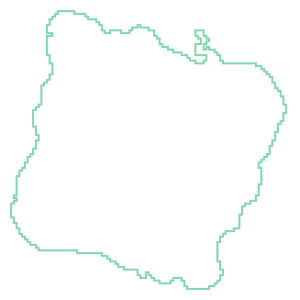

In [367]:
interiors[4]

In [358]:
[x.length for x in interiors]

[40.0, 40.0, 80.0, 40.0, 4800.0, 120.0]

In [343]:
[x.area for x in contours.iloc[-2].geometry.geoms]

[100.0, 458600.0, 400.0, 1100.0, 1600.0, 100.0, 600.0, 100.0]

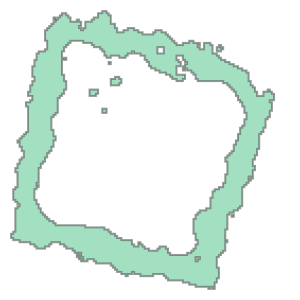

In [344]:
contours.iloc[-2].geometry

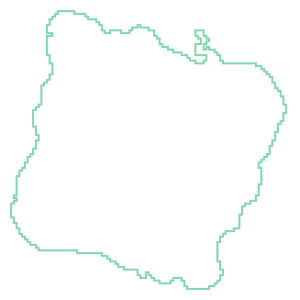

In [342]:
contours.iloc[-2].geometry.geoms[1].interiors[4]

In [101]:
[(levels[i],  levels[i + 1]) for i in range(len(levels) - 1)]

[(0, 150),
 (150, 300),
 (300, 450),
 (450, 600),
 (600, 750),
 (750, 900),
 (900, 1000)]

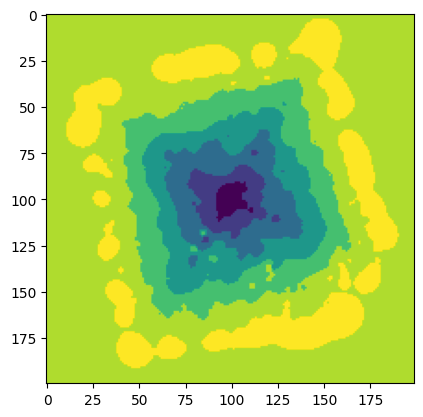

<Axes: >

In [102]:
show(img)

In [108]:
# Extract features (connected component geometries) for every pixel value
for contour in features.shapes(img, transform=transform):
    shape(contour_geom), contour_val = contour

SyntaxError: cannot assign to function call (4239019299.py, line 3)

In [107]:
# contour_geom

In [121]:
contour

NameError: name 'contour' is not defined

In [124]:
wkt.loads('POLYGON ((611932.007320461 5039745.332108863, 612032.007320461 5039745.332108863, 612032.007320461 5039770.332108863, 612007.007320461 5039770.332108863, 612007.007320461 5039795.332108863, 612032.007320461 5039795.332108863, 61
2032.007320461 5039845.332108863, 612057.007320461 5039845.332108863, 612057.007320461 5039870.332108863, 612007.007320461 5039870.332108863, 612007.007320461 5039895.332108863, 611982.007320461 5039895.332108863, 611982.0073204
61 5039920.332108863, 611932.007320461 5039920.332108863, 611932.007320461 5039895.332108863, 611907.007320461 5039895.332108863, 611907.007320461 5039770.332108863, 611932.007320461 5039770.332108863, 611932.007320461 5039745.332108863))')

SyntaxError: EOL while scanning string literal (2564248194.py, line 1)

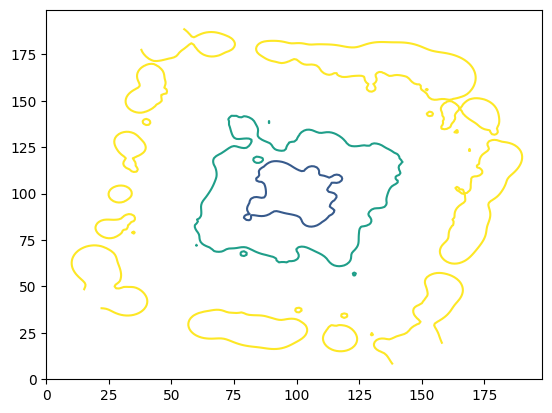

In [53]:
plt.contour(out_img.squeeze(), levels=[0,250,500,900])

In [54]:
cmd = 'gdal_contour -a dist -i 250 gdal_idw.tif gdal_contour.geojson'
os.system(cmd)

0

In [82]:
# IDW with gdal

# Save points to geojson
pts_file = r'./pts.geojson'
node_dists.to_crs(utm_crs)[['dist', 'geometry']].to_file(pts_file, driver='GeoJSON')

# GDAL IDW
cmd = f'gdal_grid -l pts -a invdist:power=3.0:smoothing=5.0:radius1=0.0:radius2=0.0:angle=0.0:max_points=0:min_points=0:nodata=0.0 -zfield dist pts.geojson gdal_idw.tif'
os.system(cmd)

0

In [13]:
node_dists

,dist,y,x,street_count,highway,ref,geometry,color_hex,color_rgb
osmid,,,,,,,,,
29794281,0.000,45.503035,-73.566340,4,NaN,NaN,POINT (-73.56634 45.50304),#a50026,"[165, 0, 38]"
10054383451,11.863,45.503131,-73.566273,4,crossing,NaN,POINT (-73.56627 45.50313),#ab0626,"[170, 5, 38]"
10054383450,12.435,45.502991,-73.566194,4,crossing,NaN,POINT (-73.56619 45.50299),#ab0626,"[170, 5, 38]"
10054383452,12.604,45.502931,-73.566404,4,crossing,NaN,POINT (-73.56640 45.50293),#ab0626,"[170, 5, 38]"
29796361,12.628,45.503073,-73.566493,5,NaN,NaN,POINT (-73.56649 45.50307),#ab0626,"[170, 5, 38]"
...,...,...,...,...,...,...,...,...,...
7546075920,998.904,45.496518,-73.561034,4,crossing,NaN,POINT (-73.56103 45.49652),#006837,"[0, 104, 55]"
4612110457,999.256,45.497348,-73.573913,3,NaN,NaN,POINT (-73.57391 45.49735),#006837,"[0, 104, 55]"
511838964,999.270,45.496092,-73.566349,3,NaN,NaN,POINT (-73.56635 45.49609),#006837,"[0, 104, 55]"


In [15]:
transform

Affine(10.050251256277312, 0.0, 610994.507320461,
       0.0, -10.000000000004656, 5040832.832108863)

In [117]:
img_masked

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=1e+20,
  dtype=float32)

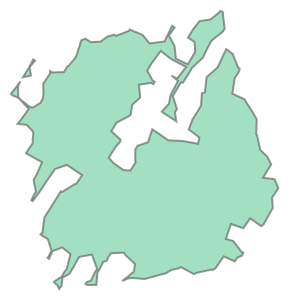

In [20]:
shape_concave

In [17]:
type(shape_concave)

shapely.geometry.multipolygon.MultiPolygon

In [24]:
if shape_concave.geom_type.lower() == 'mulitpolygon':
    
    shape_concave.geom_count

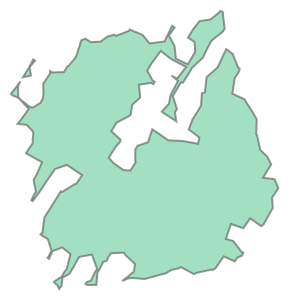

In [71]:
p = MultiPolygon([Polygon(p.exterior) for p in shape_concave.geoms]).buffer(0)
p

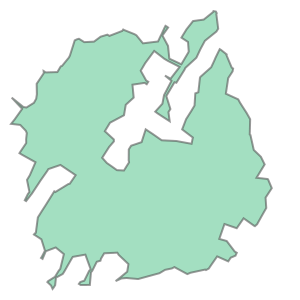

In [57]:
Polygon(p.exterior)

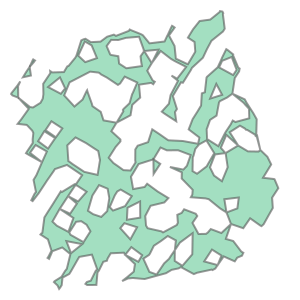

In [49]:
shape_concave

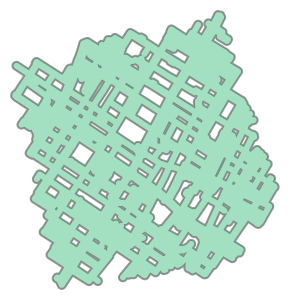

In [81]:
acc_edges.to_crs(utm_crs).buffer(25, cap_style='round').unary_union

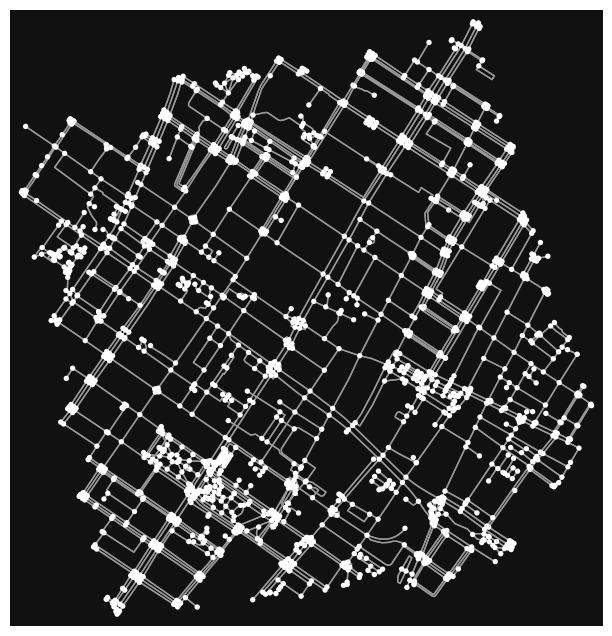

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
ox.plot_graph(subgraph)

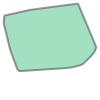

In [10]:
acc_nodes.unary_union.convex_hull

In [98]:
pts = list(acc_nodes.to_crs(utm_crs).geometry.apply(lambda p: (p.x, p.y)))

In [101]:
alphashape.circumradius(pts)

8859.214296296954

C:\Users\arthu\AppData\Local\Temp\ipykernel_23156\1417119341.py:1: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  get_alpha_shape_polygon(pts, 50)
C:\Users\arthu\miniconda3\envs\mybase\lib\site-packages\geonetworkx\tools\isochrones.py:169: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return cascaded_union(filtered_polygons)


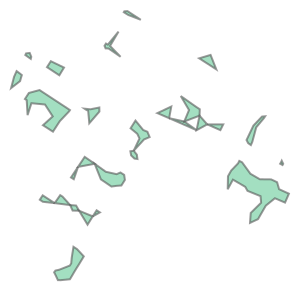

In [108]:
get_alpha_shape_polygon(pts, 50)

In [102]:
alphashape.circumcenter(pts)

array([ 2.37906254e+09, -1.82277174e+09, -1.16114135e+09, -2.76923287e+09,
        8.81123869e+08, -8.09478155e+07,  3.45174580e+08,  1.81183253e+09,
       -3.58858587e+08, -5.05021651e+08, -2.07703690e+09,  1.52867849e+09,
       -8.72847565e+08,  2.82813227e+09, -5.55189665e+08, -3.25391749e+08,
        1.01330331e+09, -7.06809472e+07, -6.03088048e+08,  1.12617144e+09,
       -1.98791083e+09,  1.14311565e+09,  7.25096095e+08, -9.36478351e+08,
       -6.01037441e+08, -7.69482361e+07,  3.92801148e+08,  5.09859031e+08,
        1.46133568e+08, -8.51867394e+08,  1.57489986e+09, -1.93324962e+09,
        7.79719307e+08, -2.09282466e+07,  6.31854054e+08, -9.90161536e+08,
        1.03166650e+08, -8.07017623e+08,  4.78930054e+08,  1.33305544e+09,
       -8.38038422e+07, -7.57601972e+08, -5.24432507e+07, -5.86885795e+08,
       -4.76532473e+08, -4.17188396e+08, -2.45257171e+07, -1.12521767e+09,
       -1.29670527e+08,  1.54998580e+09,  5.39122909e+08, -4.09689587e+07,
       -4.17474789e+08,  

In [103]:
alphashape.optimizealpha(pts)

TypeError: 'MultiPoint' object is not iterable

In [99]:
alphashape.alphashape(pts)

TypeError: 'MultiPoint' object is not iterable

In [11]:
acc_shape_convex = gpd.GeoDataFrame(geometry=[acc_nodes.unary_union.convex_hull], crs='epsg:4326')
acc_shape_convex.explore()

In [11]:
nodes[nodes.index == start_node]

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
29794281,45.503035,-73.56634,4,NaN,NaN,POINT (-73.56634 45.50304)


In [6]:
edges

,,,osmid,oneway,name,highway,maxspeed,width,reversed,length,lanes,geometry,tunnel,service,access,ref,bridge
u,v,key,,,,,,,,,,,,,,,
208756273,208756278,0,19896812,False,Rue Belmont,service,NaN,NaN,False,171.374,NaN,"LINESTRING (-73.56658 45.50079, -73.56658 45.5...",NaN,alley,permissive,NaN,NaN
208756278,208756273,0,19896812,False,Rue Belmont,service,NaN,NaN,True,171.374,NaN,"LINESTRING (-73.56658 45.50079, -73.56658 45.5...",NaN,alley,permissive,NaN,NaN
32125079,32125080,0,455083986,False,Boulevard Robert-Bourassa,secondary,50,NaN,False,85.417,4,"LINESTRING (-73.56622 45.50115, -73.56608 45.5...",NaN,NaN,NaN,NaN,NaN
32125170,32125171,0,479572754,False,Boulevard Robert-Bourassa,secondary,50,NaN,False,80.821,4,"LINESTRING (-73.56528 45.50093, -73.56602 45.5...",NaN,NaN,NaN,NaN,NaN
32125171,32125170,0,479572754,False,Boulevard Robert-Bourassa,secondary,50,NaN,True,80.821,4,"LINESTRING (-73.56602 45.50133, -73.56528 45.5...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281789721,10054383451,0,"[546096657, 455083973]",False,Boulevard René-Lévesque Ouest,secondary,50,NaN,True,61.683,3,"LINESTRING (-73.56589 45.50362, -73.56625 45.5...",NaN,NaN,NaN,NaN,NaN
29796360,10054383453,0,"[455083978, 546096658]",False,Boulevard René-Lévesque Ouest,secondary,50,NaN,False,143.933,3,"LINESTRING (-73.56555 45.50432, -73.56636 45.5...",NaN,NaN,NaN,NaN,NaN
10054383453,29796360,0,"[455083978, 546096658]",False,Boulevard René-Lévesque Ouest,secondary,50,NaN,True,143.933,3,"LINESTRING (-73.56643 45.50318, -73.56636 45.5...",NaN,NaN,NaN,NaN,NaN


In [144]:
! pip install shapelysmooth

     ---------------------------------------- 64.2/64.2 kB 1.1 MB/s eta 0:00:00


In [12]:
! pip install alphashape

     -------------------------------------- 681.1/681.1 kB 8.6 MB/s eta 0:00:00
     ------------------------------------- 433.3/433.3 kB 13.6 MB/s eta 0:00:00


In [23]:
!pip install gdal

  Using cached GDAL-3.7.0.tar.gz (775 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for gdal
Failed to build gdal
  Running setup.py install for gdal: started
  Running setup.py install for gdal: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [117 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\gdal.py -> build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\gdalconst.py -> build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\gdalnumeric.py -> build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\gdal_array.py -> build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\gnm.py -> build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\ogr.py -> build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\osr.py -> build\lib.win-amd64-cpython-39\osgeo
  copying osgeo\__init__.py -> build\lib.win-amd64-cpython-39\osgeo
  creating build\lib.win-amd64-cpython-39\osgeo_utils
  copying gdal-utils\osgeo_utils\gdal2tiles.py -> build\lib.win-amd64-cpython-39\osgeo_utils
  copying gdal-util